In [43]:
import torch
import nbimporter
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from two_sats import SatelliteDataset, ConvNet
from sentinal_1 import Sentinel1Dataset, Sentinel1ConvNet
from sentinal_2 import Sentinel2Dataset, Sentinel2ConvNet


def evaluate_and_plot(model, test_loader, dataset_type, num_classes=9, device="cuda"):
    """
    Evaluates the model and plots a bar graph showing correct and incorrect predictions for each label.

    Args:
        model: The trained model to evaluate.
        test_loader: DataLoader for the test dataset.
        dataset_type: Type of dataset ("SatelliteDataset", "Sentinel1Dataset", "Sentinel2Dataset").
        num_classes: Number of classes.
        device: Device for computation ("cuda" or "cpu").
    """
    model.to(device)
    model.eval()

    true_labels = []
    predicted_labels = []

    # Iterate through the test dataset
    with torch.no_grad():
        for data in test_loader:
            if dataset_type == "SatelliteDataset":
                sen1, sen2, labels = data
                sen1, sen2, labels = sen1.to(device), sen2.to(device), labels.to(device)
                outputs = model(sen1, sen2)  # Model with both Sentinel-1 and Sentinel-2 data
            elif dataset_type == "Sentinel1Dataset":
                sen1, labels = data
                sen1, labels = sen1.to(device), labels.to(device)
                outputs = model(sen1)  # Model with Sentinel-1 data only
            elif dataset_type == "Sentinel2Dataset":
                sen2, labels = data
                sen2, labels = sen2.to(device), labels.to(device)
                outputs = model(sen2)  # Model with Sentinel-2 data only
            else:
                raise ValueError(f"Unsupported dataset type: {dataset_type}")

            # Get predicted labels
            preds = torch.argmax(outputs, dim=1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    # Convert to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=np.arange(num_classes))

    # Calculate correct and incorrect predictions per label
    correct_per_label = np.diag(cm)
    total_per_label = cm.sum(axis=1)
    incorrect_per_label = total_per_label - correct_per_label

    # Plot the results
    plt.figure(figsize=(12, 6))
    x = np.arange(num_classes)
    bar_width = 0.4

    # Bars for correct and incorrect predictions
    correct_bars = plt.bar(x - bar_width / 2, correct_per_label, width=bar_width, label="Correct", color="green")
    incorrect_bars = plt.bar(x + bar_width / 2, incorrect_per_label, width=bar_width, label="Incorrect", color="red")

    # Add text labels above bars
    for bar in correct_bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{int(height)}", ha="center", va="bottom")

    for bar in incorrect_bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{int(height)}", ha="center", va="bottom")

    # Formatting
    plt.xticks(ticks=x, labels=np.arange(num_classes))
    plt.title("Correct vs Incorrect Predictions per Label")
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(axis="y")
    plt.show()



In [44]:
h5_file_path_test = r"C:\Users\nadav.k\Documents\DS\DL_classification\classification_data\testing.h5"
with h5py.File(h5_file_path_test, 'r') as h5_test:
    test_sen1_data = h5_test['sen1'][:]  # Load Sentinel-1 data
    test_sen2_data = h5_test['sen2'][:]  # Load Sentinel-2 data
    test_labels = h5_test['new_labels'][:]    # Load labels

In [45]:
def load_model(model_class, path, num_classes=9, device="cuda"):
    """
    Load a saved model from the specified path.

    Args:
        model_class: The class of the model to instantiate.
        path: Full path to the saved model (e.g., './models/sentinel2_classification_model.pth').
        num_classes: Number of classes for the model.
        device: Device to load the model ('cuda' or 'cpu').

    Returns:
        The loaded model.
    """
    model = model_class(num_classes=num_classes)
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Model loaded from {path}")
    return model


C:\Users\nadav.k\AppData\Local\Temp\ipykernel_22324\3971147231.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=devic

Model loaded from C:\Users\nadav.k\Documents\DS\DL_classification\saved_models\two_stas_best_manual_fulldata_new_labels.pth


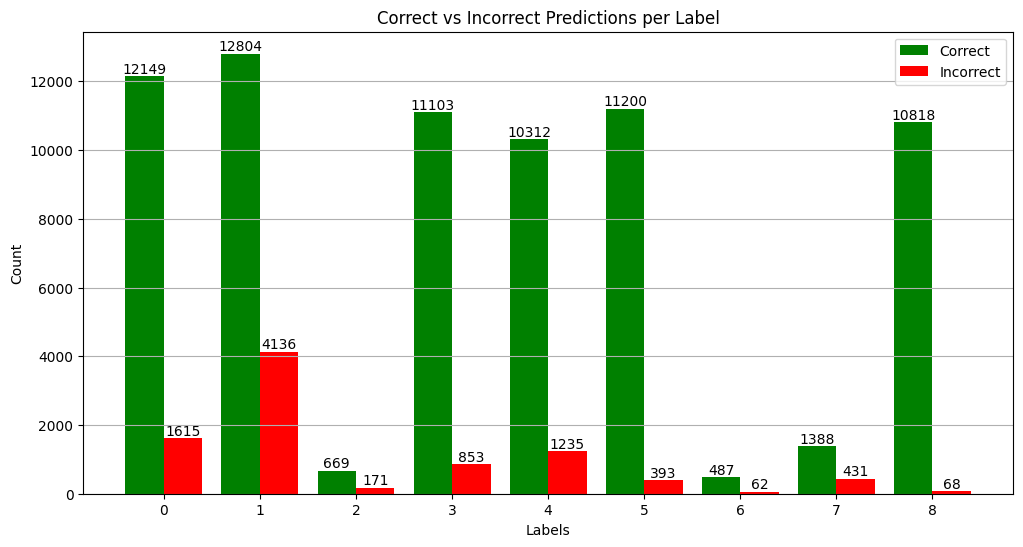

In [46]:
# Example usage
# Assuming you have already defined SatelliteDataset, Sentinel1Dataset, Sentinel2Dataset, and the model class

from torch.utils.data import DataLoader

# Load the dataset
test_loader = DataLoader(
    dataset=SatelliteDataset(sen1_data=test_sen1_data, sen2_data=test_sen2_data, labels=test_labels),
    batch_size=64,
    shuffle=False
)

# # Load the dataset
# test_loader = DataLoader(
#     dataset=Sentinel1Dataset(sen1_data=test_sen1_data, labels=test_labels),
#     batch_size=64,
#     shuffle=False
# )

# # Load the dataset
# test_loader = DataLoader(
#     dataset=Sentinel2Dataset(sen2_data=test_sen2_data, labels=test_labels),
#     batch_size=64,
#     shuffle=False
# )

saved_model_path = r"C:\Users\nadav.k\Documents\DS\DL_classification\saved_models\two_stas_best_manual_fulldata_new_labels.pth"
# Load the trained model
model = load_model(ConvNet,saved_model_path)

# Evaluate and plot
evaluate_and_plot(model, test_loader, dataset_type="SatelliteDataset", num_classes=9, device="cuda")